In [149]:
import pandas as pd
import pymongo
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# import json
import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

from datetime import datetime
import boto3
import os
import time
import subprocess

In [42]:
from data.get_data import get_download_links

links_df = get_download_links()
links_df.head(20)

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
5,2006-05,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
6,2006-06,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
7,2006-07,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
8,2006-08,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
9,2006-09,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [33]:
def calculate_polarity(month):
    """Calculate the polarity of each comment within a month. Update mongodb 
    collection with this data point."""

    sia = SIA()
    
    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    cursor = collection.find({'$and': 
                                   [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                    {'$expr': {'$gt': ['$score', 0]}}]
                           })

    for doc in cursor:
        _id = doc['_id']
        sentiment = sia.polarity_scores(doc['body'])['compound']
        collection.update_one({"_id": _id}, {"$set": {"vader_sentiment": sentiment}})
    
    client.close()

In [161]:
def monthly_statistics(month, subreddit=None, link_ids=None):
    """Returns the average absolute sentiment polarity of a comment within a given month."""

    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    if link_ids is not None:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}},
                                        {'link_id': {'$in': link_ids}}]
                                })
    
    elif subreddit == None:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}}]
                                })
    else:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}},
                                        {'subreddit': subreddit}]
                                })
    
    total_n_words = 0
    total_abs_polarity = 0
    total_score = 0
    comment_count = 0
    for doc in cursor:
        try:
            total_n_words += len(doc['body'].split())
        except:
            pass
        total_abs_polarity += doc['score']*abs(doc['vader_sentiment'])
        total_score += doc['score']
        comment_count += 1

    try:
        avg_abs_polarity = total_abs_polarity/total_score
    except ZeroDivisionError:
        avg_abs_polarity = None
    
    try:
        avg_comment_count = total_n_words/comment_count
    except ZeroDivisionError:
        avg_comment_count = None
    
    client.close()
    
    return avg_abs_polarity, comment_count, avg_comment_count

In [ ]:
for idx, row in links_df.loc[120:144].iterrows():
    month = row['month']

    print('{}:\t{}'.format(idx,month), end='   ')
    start = time.time()
    calculate_polarity(month)
    print('Done in {:1.1f} seconds'.format(time.time() - start))

120:	2015-12   Done in 116.0 seconds
121:	2016-01   Done in 149.5 seconds
122:	2016-02   Done in 249.1 seconds
123:	2016-03   Done in 395.7 seconds
124:	2016-04   Done in 320.4 seconds
125:	2016-05   Done in 301.8 seconds
126:	2016-06   Done in 333.2 seconds
127:	2016-07   Done in 438.6 seconds
128:	2016-08   Done in 358.1 seconds
129:	2016-09   Done in 483.8 seconds
130:	2016-10   Done in 756.2 seconds
131:	2016-11   Done in 896.3 seconds
132:	2016-12   Done in 549.8 seconds
133:	2017-01   

In [109]:
def get_sentiment(m_start, m_end, df, subreddit=None):

    d = {}
    for idx, row in df.loc[m_start:m_end].iterrows():
        month = row['month']
        if idx % 10 == 0:
            print(idx, month)
        aap, comment_count, avg_wordcount = monthly_statistics(month, subreddit=subreddit)
        d[month] = {'avg_abs_pol': aap, 'comment_count': comment_count, 'avg_wordcount': avg_wordcount}

    return d

In [134]:
comment_thresh = 5000

politics_data = get_sentiment(20, 144, links_df, subreddit='politics')
politics_data = {k: v for k, v in politics_data.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


In [ ]:
sm.add_constant(to_col_vector(arr), prepend=False)
X = make_design_matrix(np.arange(len(series)) + 1)
linear_trend_ols = sm.OLS(series.values, X).fit()
linear_trend = linear_trend_ols.predict(X)

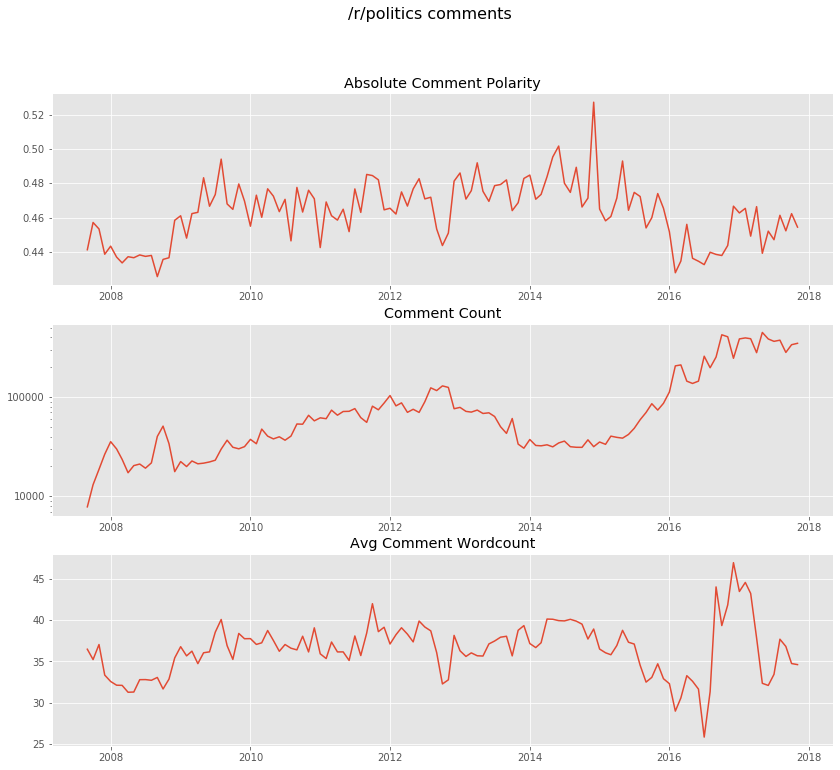

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(14,12))
fig.suptitle('/r/politics comments', fontsize=16)

dates = [datetime.strptime(k, '%Y-%m') for k, _ in sorted(politics_data.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(politics_data.items())]
ccnt = [v['comment_count'] for _, v in sorted(politics_data.items())]
awc = [v['avg_wordcount'] for _, v in sorted(politics_data.items())]

axes[0].plot(dates, aap)
axes[0].set_title('Absolute Comment Polarity')
axes[1].plot(dates, ccnt)
axes[1].set_title('Comment Count')
axes[2].plot(dates, awc)
axes[2].set_title('Avg Comment Wordcount')

axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(ScalarFormatter())

In [124]:
comment_thresh = 5000

worldnews_data = get_sentiment(20, 140, links_df, subreddit='worldnews')
worldnews_data = {k: v for k, v in worldnews_data.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


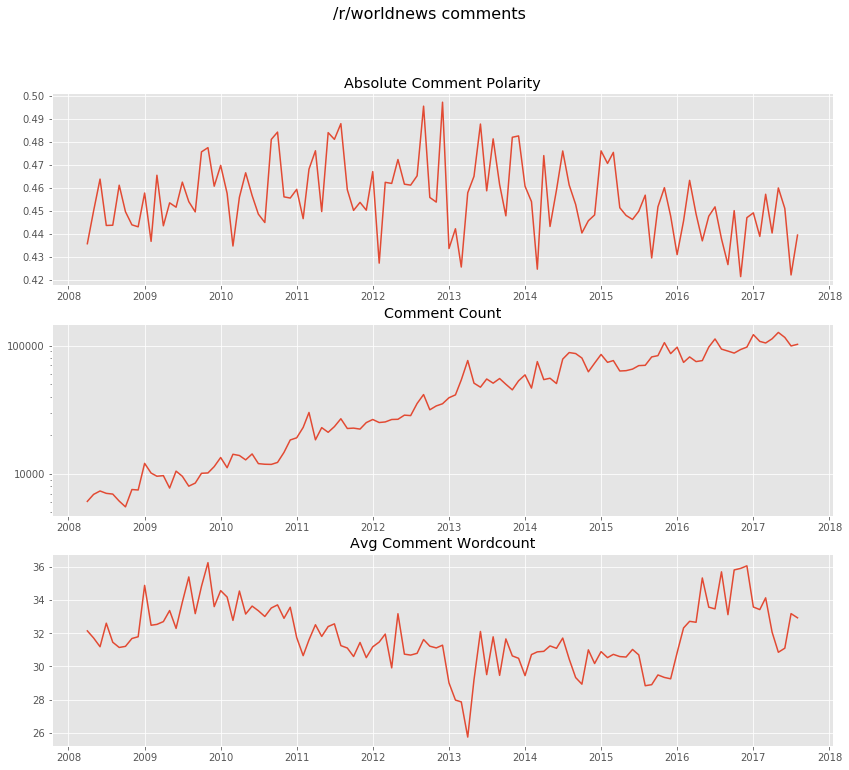

In [131]:
fig, axes = plt.subplots(3, 1, figsize=(14,12))
fig.suptitle('/r/worldnews comments', fontsize=16)

dates = [datetime.strptime(k, '%Y-%m') for k, _ in sorted(worldnews_data.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(worldnews_data.items())]
ccnt = [v['comment_count'] for _, v in sorted(worldnews_data.items())]
awc = [v['avg_wordcount'] for _, v in sorted(worldnews_data.items())]

axes[0].plot(dates, aap)
axes[0].set_title('Absolute Comment Polarity')
axes[1].plot(dates, ccnt)
axes[1].set_title('Comment Count')
axes[2].plot(dates, awc)
axes[2].set_title('Avg Comment Wordcount')

axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(ScalarFormatter())

# pprint.pprint(sorted(worldnews_data.items()))

In [ ]:
comment_thresh = 5000

worldnews_data = get_sentiment(20, 140, links_df, subreddit='worldnews')
worldnews_data = {k: v for k, v in worldnews_data.items() if v['comment_count'] > comment_thresh}

1. Group posts by month. Make new 'datetime' field
2. Get top 100 posts for month
3. Look at comment sentiment for those posts

In [146]:
posts_all = db['posts_all']

posts1 = posts_all.find().limit(1).next()
print(posts1)
# print(datetime.utcfromtimestamp(posts1['datetime']).strftime('%Y-%m'))
print(posts_all.distinct('yearmonth'))

{'_id': ObjectId('5e554d246960e0b4e8de88fd'), 'link_id': '2cnnc', 'title': 'Smashing interview by Ron Paul on FOX!  "Just come home"', 'score': 61, 'is_self': False, 'datetime': 1186379408.0, 'sub': 'politics', 'permalink': '/r/politics/comments/2cnnc/smashing_interview_by_ron_paul_on_fox_just_come/', 'yearmonth': '2007-08'}
['2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '

In [166]:
client = MongoClient()
db = client['myreddit']

monthly_data = {}

yearmonths = sorted(posts_all.distinct('yearmonth'))
for idx in range(len(yearmonths) - 1):
    # Get top 100 posts
    ym = yearmonths[idx]
    next_ym = yearmonths[idx + 1]

    cursor = posts_all.find({'yearmonth': ym, 'sub': 'politics'}).sort('score', pymongo.DESCENDING).limit(10)
    link_ids = [post['link_id'] if post['link_id'].startswith('t3_') else 't3_' + post['link_id'] for post in cursor]

    collection_name = 'comments-' + ym
    next_collection_name = 'comments-' + next_ym
    collection = db[collection_name]
    next_collection = db[next_collection_name]
    
    
    
    total_n_words = 0
    total_abs_weighted_polarity = 0
    total_abs_polarity = 0
    total_score = 0
    comment_count = 0
    
    for coll in [collection, next_collection]:
        cursor = coll.find({'$and': 
                                [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                 {'$expr': {'$gt': ['$score', 0]}},
                                 {'link_id': {'$in': link_ids}}]
                            })
        for doc in cursor:
            try:
                total_n_words += len(doc['body'].split())
            except:
                pass
            total_abs_weighted_polarity += doc['score']*abs(doc['vader_sentiment'])
            total_abs_polarity += abs(doc['vader_sentiment'])
            total_score += doc['score']
            comment_count += 1

    try:
        avg_abs_weighted_polarity = total_abs_weighted_polarity/total_score
    except ZeroDivisionError:
        avg_abs_weighted_polarity = None

    try:
        avg_abs_polarity = total_abs_polarity/comment_count
    except ZeroDivisionError:
        avg_abs_polarity = None

    try:
        avg_comment_count = total_n_words/comment_count
    except ZeroDivisionError:
        avg_comment_count = None
    
    
    monthly_data[ym] = {'avg_abs_wght_pol': avg_abs_weighted_polarity, 
                        'avg_abs_pol': avg_abs_polarity,
                        'comment_count': comment_count, 
                        'avg_wordcount': avg_wordcount}
    

    if idx > 3:
        break

pprint.pprint(monthly_data)

client.close()

{'2007-08': {'avg_abs_pol': 0.4265090163934426,
             'avg_abs_wght_pol': 0.4535185388127855,
             'avg_wordcount': 12.780225558669962,
             'comment_count': 244},
 '2007-09': {'avg_abs_pol': 0.4319887820512818,
             'avg_abs_wght_pol': 0.4656197150430747,
             'avg_wordcount': 12.780225558669962,
             'comment_count': 312},
 '2007-10': {'avg_abs_pol': 0.45307050938337784,
             'avg_abs_wght_pol': 0.502393348115299,
             'avg_wordcount': 12.780225558669962,
             'comment_count': 373},
 '2007-11': {'avg_abs_pol': 0.44755292740046837,
             'avg_abs_wght_pol': 0.4476763958835121,
             'avg_wordcount': 12.780225558669962,
             'comment_count': 427},
 '2007-12': {'avg_abs_pol': 0.4082801242236026,
             'avg_abs_wght_pol': 0.45919192691735655,
             'avg_wordcount': 12.780225558669962,
             'comment_count': 483}}


In [160]:
def get_n_comments(db):
    """Gets number of comments across all months"""

    n_comments = 0
    for name in sorted([x for x in db.collection_names() if x.startswith('comments')]):
        coll = db[name]
        n_comments += coll.count()

    return n_comments